In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json
from shapely import geometry as sgeom
import pandas as pd

In [2]:
########## USER ###########
# Select modeling domain ('WY', 'UT', 'OR', 'WA')
domain = 'WA'

In [3]:
#CSO data path
CSOpath = 'cso-data.geojson'

#path to CSO domain json
with open('/nfs/attic/dfh/Aragon2/CSOdata/CSO_domains.json') as f:
    domains = json.load(f)

#start date    
st = domains[domain]['st']
#end date
ed = domains[domain]['ed']

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# CSO projection
stn_proj = domains[domain]['stn_proj']

# CSO projection
mod_proj = domains[domain]['mod_proj']

In [4]:
gdf = gpd.read_file(CSOpath)

In [5]:
# Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)

In [6]:
CSO_gdf = gpd.sjoin(gdf, box_gdf, how="inner")
CSO_gdf.drop(columns='index_right', inplace=True)
CSO_gdf.reset_index(drop=True, inplace=True)
CSO_gdf.head()

,id,author,depth,source,timestamp,elevation,_ms,geometry
0,0FIbt71c,Bob Sutherland,61.999998,MountainHub,2020-01-05T20:04:08,980.924622,1578254648880,POINT (-120.51831 48.59405)
1,0T3SEQNz,Yasmine Hentati,27.000000,MountainHub,2020-01-14T19:57:54,1051.207520,1579031874034,POINT (-120.15264 48.30681)
2,1OaGvegg,Bob Sutherland,60.959999,MountainHub,2019-01-05T20:44:26,1155.734619,1546721066939,POINT (-120.32428 48.58304)
3,1xmy9hHt,Bob Sutherland,109.999996,MountainHub,2020-01-30T19:48:48,900.381226,1580413728183,POINT (-120.56573 48.64941)
4,20OQ9cvy,David Hill,35.000000,MountainHub,2020-01-03T16:58:12,1234.039551,1578070692193,POINT (-120.29480 48.56598)


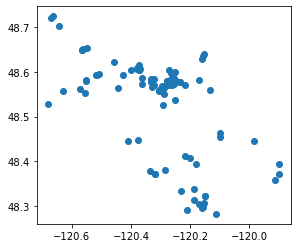

In [7]:
CSO_gdf.plot()

In [8]:

CSO_gdf['dt'] = pd.to_datetime(CSO_gdf['timestamp'], format='%Y-%m-%dT%H:%M:%S')

In [26]:
CSO_gdf['Y'] = pd.DatetimeIndex(CSO_gdf['dt']).year
CSO_gdf['M'] = pd.DatetimeIndex(CSO_gdf['dt']).month
CSO_gdf['D'] = pd.DatetimeIndex(CSO_gdf['dt']).day
CSO_gdf["LON"] = CSO_gdf.geometry.x
CSO_gdf["LAT"] = CSO_gdf.geometry.y
#convert snow depth to m
CSO_gdf['H'] = CSO_gdf.depth/100
CSO_gdf.head()

,id,author,depth,source,timestamp,elevation,_ms,geometry,dt,Y,M,D,H,LON,LAT
0,0FIbt71c,Bob Sutherland,61.999998,MountainHub,2020-01-05T20:04:08,980.924622,1578254648880,POINT (-120.51831 48.59405),2020-01-05 20:04:08,2020,1,5,0.6200,-120.518315,48.594050
1,0T3SEQNz,Yasmine Hentati,27.000000,MountainHub,2020-01-14T19:57:54,1051.207520,1579031874034,POINT (-120.15264 48.30681),2020-01-14 19:57:54,2020,1,14,0.2700,-120.152640,48.306807
2,1OaGvegg,Bob Sutherland,60.959999,MountainHub,2019-01-05T20:44:26,1155.734619,1546721066939,POINT (-120.32428 48.58304),2019-01-05 20:44:26,2019,1,5,0.6096,-120.324281,48.583038
3,1xmy9hHt,Bob Sutherland,109.999996,MountainHub,2020-01-30T19:48:48,900.381226,1580413728183,POINT (-120.56573 48.64941),2020-01-30 19:48:48,2020,1,30,1.1000,-120.565732,48.649405
4,20OQ9cvy,David Hill,35.000000,MountainHub,2020-01-03T16:58:12,1234.039551,1578070692193,POINT (-120.29480 48.56598),2020-01-03 16:58:12,2020,1,3,0.3500,-120.294798,48.565985


In [19]:
print('Total number of CSO in daimain = ',len(CSO_gdf))

Total number of CSO in daimain =  96


In [31]:
CSO_gdf = CSO_gdf.set_index(['dt'])
print('Total number of CSO in daimain within time bounds = ',len(CSO_gdf.loc[st:ed]))

Total number of CSO in daimain within time bounds =  50


In [32]:
CSO_gdf = CSO_gdf.loc[st:ed]
CSO_gdf.head()

,id,author,depth,source,timestamp,elevation,_ms,geometry,Y,M,D,H,LON,LAT
dt,,,,,,,,,,,,,,
2019-01-05 20:44:26,1OaGvegg,Bob Sutherland,60.959999,MountainHub,2019-01-05T20:44:26,1155.734619,1546721066939,POINT (-120.32428 48.58304),2019,1,5,0.6096,-120.324281,48.583038
2019-01-27 20:53:49,3qzREUvP,Bob Sutherland,66.039999,MountainHub,2019-01-27T20:53:49,1255.831299,1548622429422,POINT (-119.90039 48.37044),2019,1,27,0.6604,-119.900394,48.370441
2019-01-02 19:33:55,4ucRx0h/,David Hill,52.000000,MountainHub,2019-01-02T19:33:55,1097.364502,1546457635418,POINT (-120.27369 48.57929),2019,1,2,0.5200,-120.273685,48.579292
2019-01-02 20:06:18,5JFbZLqM,David Hill,50.000000,MountainHub,2019-01-02T20:06:18,1084.137817,1546459578087,POINT (-120.26595 48.59800),2019,1,2,0.5000,-120.265946,48.598001
2018-12-31 19:54:08,7TVYuf6q,David Hill,50.000000,MountainHub,2018-12-31T19:54:08,945.443542,1546286048752,POINT (-120.25446 48.57377),2018,12,31,0.5000,-120.254464,48.573765


# Hs to SWE

In [30]:
from Depth2SWE import swe_calc

In [36]:
SWE,DOY = swe_calc(CSO_gdf.Y.values,CSO_gdf.M.values,CSO_gdf.D.values,
                   CSO_gdf.H.values,CSO_gdf.LAT.values,CSO_gdf.LON.values)

In [37]:
CSO_gdf['SWE'] = SWE
CSO_gdf['DOY'] = DOY
CSO_gdf.head()

,id,author,depth,source,timestamp,elevation,_ms,geometry,Y,M,D,H,LON,LAT,SWE,DOY
dt,,,,,,,,,,,,,,,,
2019-01-05 20:44:26,1OaGvegg,Bob Sutherland,60.959999,MountainHub,2019-01-05T20:44:26,1155.734619,1546721066939,POINT (-120.32428 48.58304),2019,1,5,0.6096,-120.324281,48.583038,0.214435,97.0
2019-01-27 20:53:49,3qzREUvP,Bob Sutherland,66.039999,MountainHub,2019-01-27T20:53:49,1255.831299,1548622429422,POINT (-119.90039 48.37044),2019,1,27,0.6604,-119.900394,48.370441,0.206832,119.0
2019-01-02 19:33:55,4ucRx0h/,David Hill,52.000000,MountainHub,2019-01-02T19:33:55,1097.364502,1546457635418,POINT (-120.27369 48.57929),2019,1,2,0.5200,-120.273685,48.579292,0.178881,94.0
2019-01-02 20:06:18,5JFbZLqM,David Hill,50.000000,MountainHub,2019-01-02T20:06:18,1084.137817,1546459578087,POINT (-120.26595 48.59800),2019,1,2,0.5000,-120.265946,48.598001,0.173813,94.0
2018-12-31 19:54:08,7TVYuf6q,David Hill,50.000000,MountainHub,2018-12-31T19:54:08,945.443542,1546286048752,POINT (-120.25446 48.57377),2018,12,31,0.5000,-120.254464,48.573765,0.167508,92.0


## QC observations 

* 

## Organize data by various methods

* Aspect
* Elevation
* Timing
* Look up ideal temporal spatial analysis 
* Landcover class

vs random sampling 

In [15]:
#change projection 
CSO_gdf=CSO_gdf.to_crs(mod_proj)
CSO_gdf.head()

,id,author,depth,source,timestamp,elevation,_ms,geometry
dt,,,,,,,,
2020-01-05 20:04:08,0FIbt71c,Bob Sutherland,61.999998,MountainHub,2020-01-05T20:04:08,980.924622,1578254648880,POINT (682980.206 5385303.004)
2020-01-14 19:57:54,0T3SEQNz,Yasmine Hentati,27.000000,MountainHub,2020-01-14T19:57:54,1051.207520,1579031874034,POINT (711127.879 5354320.304)
2019-01-05 20:44:26,1OaGvegg,Bob Sutherland,60.959999,MountainHub,2019-01-05T20:44:26,1155.734619,1546721066939,POINT (697328.389 5384562.328)
2020-01-30 19:48:48,1xmy9hHt,Bob Sutherland,109.999996,MountainHub,2020-01-30T19:48:48,900.381226,1580413728183,POINT (679288.022 5391342.888)
2020-01-03 16:58:12,20OQ9cvy,David Hill,35.000000,MountainHub,2020-01-03T16:58:12,1234.039551,1578070692193,POINT (699569.628 5382743.595)


In [ ]:
#snow depth to swe 

# need to develop a way to QC the CSO data and create assimilation ensebles 

In [ ]:
# print as file for SM

In [19]:
import Depth2SWE

AttributeError: 'NoneType' object has no attribute 'ReadAsArray'